# 01 - Data Loading & Initial Exploration

**Objective:** Load all monthly data from original `data/` folder and perform train/test split

**Strategy:**
- **Training:** Months 1-7 (January to July 2025)
- **Testing:** Month 8 (August 2025) - chronological holdout

**Output:** `data/train_raw.csv`, `data/test_raw.csv`

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 100)
plt.style.use('default')
sns.set_palette('husl')

print(f"Notebook run: {datetime.now().isoformat()}")

Notebook run: 2025-10-24T08:44:29.471163


In [ ]:
# Configure paths (works on Windows and Linux/Amarel)
from pathlib import Path
import os

# Use current working directory as ROOT
ROOT = Path.cwd()
RAW_DATA_DIR = ROOT / 'filled_data'  # Use filled_data with better lat/long
MODELS_DIR = ROOT / 'models'

MODELS_DIR.mkdir(exist_ok=True)

print(f"ROOT: {ROOT}")
print(f"RAW_DATA_DIR exists: {RAW_DATA_DIR.exists()}")
print(f"MODELS_DIR exists: {MODELS_DIR.exists()}")

ROOT: c:\Users\lpnhu\Downloads\home-price-prediction
RAW_DATA_DIR exists: True


In [3]:
# Find all filled monthly CSV files (CRMLSSold*_filled.csv)
csv_files = sorted(RAW_DATA_DIR.glob('CRMLSSold*_filled.csv'))

print(f"Found {len(csv_files)} monthly files:")
for f in csv_files:
    print(f"  - {f.name}")

if len(csv_files) == 0:
    raise FileNotFoundError(f"No filled CSV files found in {RAW_DATA_DIR}")

Found 8 monthly files:
  - CRMLSSold202501_filled.csv
  - CRMLSSold202502_filled.csv
  - CRMLSSold202503_filled.csv
  - CRMLSSold202504_filled.csv
  - CRMLSSold202505_filled.csv
  - CRMLSSold202506_filled.csv
  - CRMLSSold202507_filled.csv
  - CRMLSSold202508_filled.csv


In [4]:
# Load and concatenate all monthly files
print("Loading all monthly files...")
dfs = []

for csv_file in csv_files:
    df = pd.read_csv(csv_file, low_memory=False)
    df['_source_file'] = csv_file.name
    dfs.append(df)
    print(f"  Loaded {csv_file.name}: {len(df):,} rows")

df_all = pd.concat(dfs, ignore_index=True)
print(f"\nTotal combined: {len(df_all):,} rows, {len(df_all.columns)} columns")

Loading all monthly files...
  Loaded CRMLSSold202501_filled.csv: 18,738 rows
  Loaded CRMLSSold202501_filled.csv: 18,738 rows
  Loaded CRMLSSold202502_filled.csv: 18,702 rows
  Loaded CRMLSSold202502_filled.csv: 18,702 rows
  Loaded CRMLSSold202503_filled.csv: 21,445 rows
  Loaded CRMLSSold202503_filled.csv: 21,445 rows
  Loaded CRMLSSold202504_filled.csv: 23,262 rows
  Loaded CRMLSSold202504_filled.csv: 23,262 rows
  Loaded CRMLSSold202505_filled.csv: 23,154 rows
  Loaded CRMLSSold202505_filled.csv: 23,154 rows
  Loaded CRMLSSold202506_filled.csv: 22,883 rows
  Loaded CRMLSSold202506_filled.csv: 22,883 rows
  Loaded CRMLSSold202507_filled.csv: 23,646 rows
  Loaded CRMLSSold202507_filled.csv: 23,646 rows
  Loaded CRMLSSold202508_filled.csv: 22,972 rows

Total combined: 174,802 rows, 81 columns
  Loaded CRMLSSold202508_filled.csv: 22,972 rows

Total combined: 174,802 rows, 81 columns


In [5]:
# Separate August 2025 (month 8) for testing
august_mask = df_all['_source_file'] == 'CRMLSSold202508_filled.csv'

df_test = df_all[august_mask].copy()
df_train = df_all[~august_mask].copy()

print(f"Training data (months 1-7): {len(df_train):,} rows")
print(f"Test data (month 8 - August): {len(df_test):,} rows")
print(f"Test set proportion: {len(df_test)/len(df_all)*100:.1f}%")

Training data (months 1-7): 151,830 rows
Test data (month 8 - August): 22,972 rows
Test set proportion: 13.1%


In [6]:
# Basic info
print(f"Dataset shape: {df_all.shape}")
print(f"\nColumn count by type:")
print(df_all.dtypes.value_counts())

Dataset shape: (174802, 81)

Column count by type:
object     49
float64    27
int64       3
bool        2
Name: count, dtype: int64


In [7]:
# Find target column
target_candidates = ['ClosePrice', 'Close Price', 'Close_Price', 'CLOSEPRICE']
target = next((c for c in target_candidates if c in df_all.columns), None)

if target is None:
    raise ValueError("Target column 'ClosePrice' not found!")

print(f"Target column: {target}")
print(f"\nTarget statistics:")
print(df_all[target].describe())

Target column: ClosePrice

Target statistics:
count    1.748000e+05
mean     8.728161e+05
std      5.630124e+06
min      0.000000e+00
25%      1.999800e+04
50%      6.176160e+05
75%      1.057000e+06
max      9.700000e+08
Name: ClosePrice, dtype: float64


In [8]:
# Missing values analysis
missing_pct = (df_all.isnull().sum() / len(df_all) * 100).sort_values(ascending=False)
missing_pct = missing_pct[missing_pct > 0]

print(f"Columns with missing values: {len(missing_pct)}")
print(f"\nTop 15 columns with most missing values:")
print(missing_pct.head(15))

Columns with missing values: 67

Top 15 columns with most missing values:
FireplacesTotal                 100.000000
ElementarySchoolDistrict        100.000000
CoveredSpaces                   100.000000
AboveGradeFinishedArea          100.000000
MiddleOrJuniorSchoolDistrict    100.000000
TaxYear                          99.939360
WaterfrontYN                     99.938216
BusinessType                     99.750003
TaxAnnualAmount                  99.645885
BelowGradeFinishedArea           99.534330
BasementYN                       98.358142
BuilderName                      96.204277
LotSizeDimensions                94.585874
CoBuyerAgentFirstName            91.901694
ElementarySchool                 89.153442
dtype: float64


In [9]:
# Target distribution
target_clean = pd.to_numeric(df_all[target], errors='coerce').dropna()

print(f"Valid target values: {len(target_clean):,} ({len(target_clean)/len(df_all)*100:.1f}%)")
print(f"\nTarget percentiles:")
for p in [1, 5, 10, 25, 50, 75, 90, 95, 99]:
    val = target_clean.quantile(p/100)
    print(f"  {p:2d}th percentile: ${val:,.0f}")

Valid target values: 174,800 (100.0%)

Target percentiles:
   1th percentile: $1,729
   5th percentile: $2,650
  10th percentile: $3,400
  25th percentile: $19,998
  50th percentile: $617,616
  75th percentile: $1,057,000
  90th percentile: $1,785,000
  95th percentile: $2,500,000
  99th percentile: $5,100,000


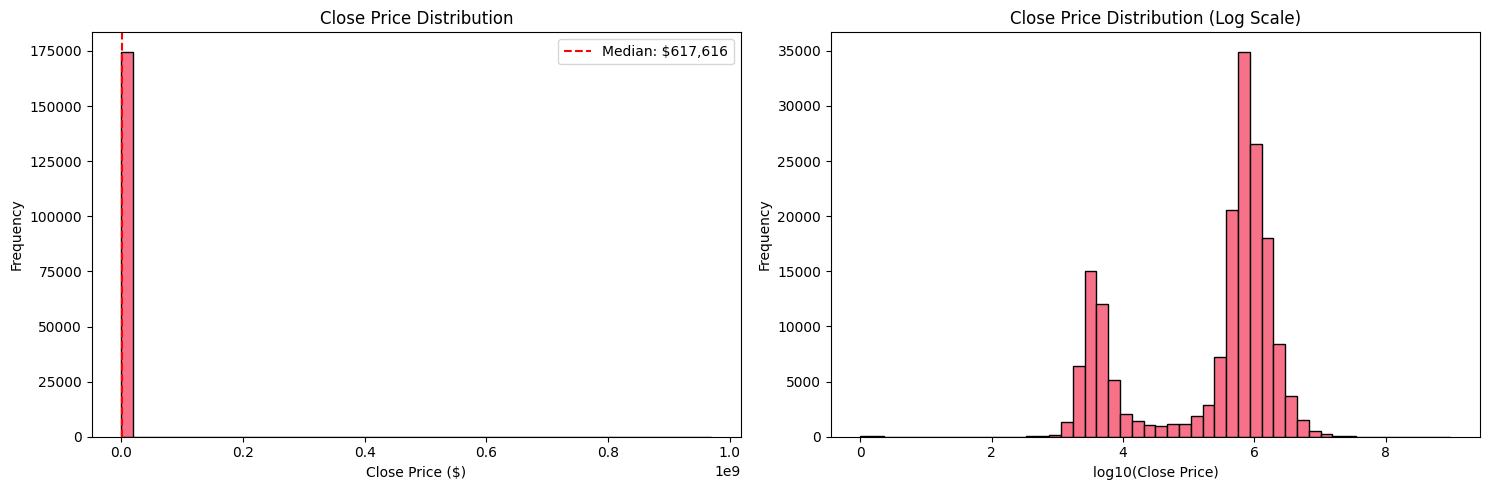


Visualization complete! Ready for preprocessing.


In [10]:
# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(target_clean, bins=50, edgecolor='black')
axes[0].set_xlabel('Close Price ($)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Close Price Distribution')
axes[0].axvline(target_clean.median(), color='red', linestyle='--', label=f'Median: ${target_clean.median():,.0f}')
axes[0].legend()

# Filter out zeros before log transform
target_positive = target_clean[target_clean > 0]
axes[1].hist(np.log10(target_positive), bins=50, edgecolor='black')
axes[1].set_xlabel('log10(Close Price)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Close Price Distribution (Log Scale)')

plt.tight_layout()
plt.show()
print(f"\nVisualization complete! Ready for preprocessing.")

In [11]:
# Save train and test sets
train_path = RAW_DATA_DIR / 'train_raw.csv'
test_path = RAW_DATA_DIR / 'test_raw.csv'

df_train.to_csv(train_path, index=False)
df_test.to_csv(test_path, index=False)

print(f"Saved training data: {train_path}")
print(f"Saved test data: {test_path}")
print(f"\n✅ Ready for preprocessing in notebook 02!")

Saved training data: c:\Users\lpnhu\Downloads\home-price-prediction\filled_data\train_raw.csv
Saved test data: c:\Users\lpnhu\Downloads\home-price-prediction\filled_data\test_raw.csv

✅ Ready for preprocessing in notebook 02!
